# Dogs Image Explortion

**The purposes of this notebook are:**

- Reading and showing the images with their annotations (class / boxes)
- Reviewing image size distribution
- Finding mean and std
- Creating a dataset class

In [1]:
import torch
# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import glob
import os.path as osp
import os
import numpy as np
from PIL import Image # to read images

import xml.etree.ElementTree as ET # for parsing XML
import matplotlib.pyplot as plt # to show images
import matplotlib.patches as patches
from tqdm import tqdm_notebook as tqdm
import time
%matplotlib inline

In [2]:
BASE_PATH = "/home/ishay/Documents/MDLI/dogs/data"
# BASE_PATH = "/home/michael/.."

## Examine directory structure and content

In [3]:
print(os.listdir(BASE_PATH))

['Annotation', 'Images']


**Images**

In [4]:
breed_list = os.listdir(BASE_PATH + "/Images")[:5]

In [5]:
# Print first 5 breeds in Images
print(breed_list[:5])

['n02096437-Dandie_Dinmont', 'n02088632-bluetick', 'n02091635-otterhound', 'n02091134-whippet', 'n02106550-Rottweiler']


In [6]:
# Examine first 5 breeds without code number
[breed.split("-")[1] for breed in os.listdir(BASE_PATH + "/Images")][:5]

['Dandie_Dinmont', 'bluetick', 'otterhound', 'whippet', 'Rottweiler']

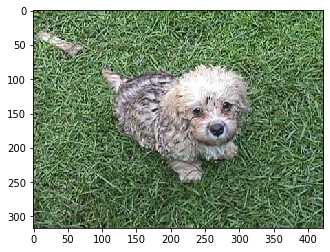

In [7]:
# Show the first data in the dataset
img_name = os.listdir(BASE_PATH + "/Images/" + breed_list[0])[0]
img_path = BASE_PATH + "/Images/" + breed_list[0] + "/" + img_name

img = plt.imread(img_path)
plt.imshow(img)

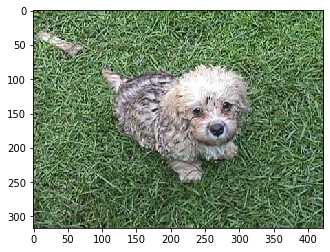

In [8]:
# An alternative way to read the images
img = Image.open(img_path)
plt.imshow(img)

In [9]:
img_path

'/home/ishay/Documents/MDLI/dogs/data/Images/n02096437-Dandie_Dinmont/n02096437_3289.jpg'

**Annotation**

In [10]:
# Print first 5 breeds in Annotation
print(os.listdir(BASE_PATH + "/Annotation")[:5])

['n02096437-Dandie_Dinmont', 'n02088632-bluetick', 'n02091635-otterhound', 'n02091134-whippet', 'n02106550-Rottweiler']


**They look the same as in 'Images'**

In [11]:
# Get the box of that image
annot_name = img_name.split(".")[0]
annot_path = BASE_PATH + "/Annotation/" + breed_list[0] + "/" + annot_name

In [12]:
annot_path

'/home/ishay/Documents/MDLI/dogs/data/Annotation/n02096437-Dandie_Dinmont/n02096437_3289'

In [13]:
tree = ET.parse(annot_path)

In [14]:
tree

Text(0, -20, 'Dandie_Dinmont')

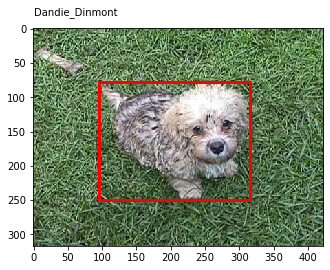

In [15]:
root = tree.getroot() # idk what's it but it's from documentation
objects = root.findall('object') # An array
plt.imshow(img) # displays photo
for o in objects:
    bndbox = o.find('bndbox') # reading border coordinates
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
# showing border
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],  linewidth=3, c="r")
# Showing text on a white patch
rect = patches.Rectangle((0,0),150,40,linewidth=1,edgecolor='none',facecolor='w')
plt.text(0, -20, o.find('name').text)

Taken from: https://www.kaggle.com/gtimoshaz/dataset-reading-demo

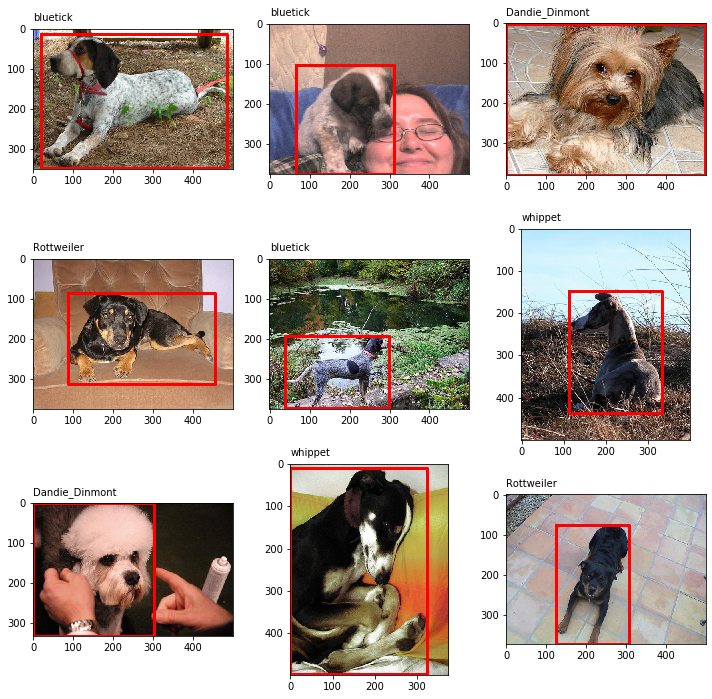

In [16]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # showing 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir(BASE_PATH + '/Annotation/' + breed)) # random image 
    img = Image.open(BASE_PATH + '/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse(BASE_PATH + '/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() # idk what's it but it's from documentation
    objects = root.findall('object') # finding all dogs. An array
    plt.imshow(img) # displays photo
    for o in objects:
        bndbox = o.find('bndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],  linewidth=3, c="r") # showing border
    plt.text(0, -20, o.find('name').text)
fig.tight_layout()

## Examine Images Size

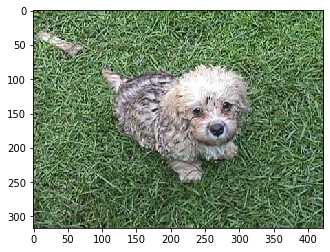

In [17]:
img = Image.open(img_path)
plt.imshow(img)

In [18]:
img.size

(423, 317)

In [19]:
# Get the size of all images
sizes = []
for breed in tqdm(breed_list):
    for img_name in os.listdir(BASE_PATH + "/Images/" + breed):
        img_path = BASE_PATH + "/Images/" + breed + "/" + img_name
        img = Image.open(img_path)
        img_size = img.size
        sizes.append(img_size)

/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


##### Examine number of images
len(sizes)

In [20]:
widths = [size[0] for size in sizes]
lengths = [size[1] for size in sizes]

Text(0, 0.5, 'Frequency')

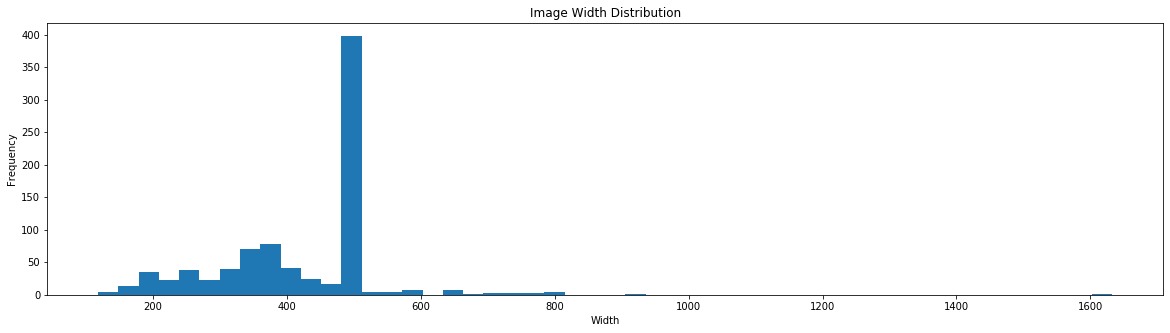

In [21]:
# Plot histograms
plt.figure(figsize=(20, 5))
plt.hist(widths, bins=50)
plt.title("Image Width Distribution")
plt.xlabel("Width")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

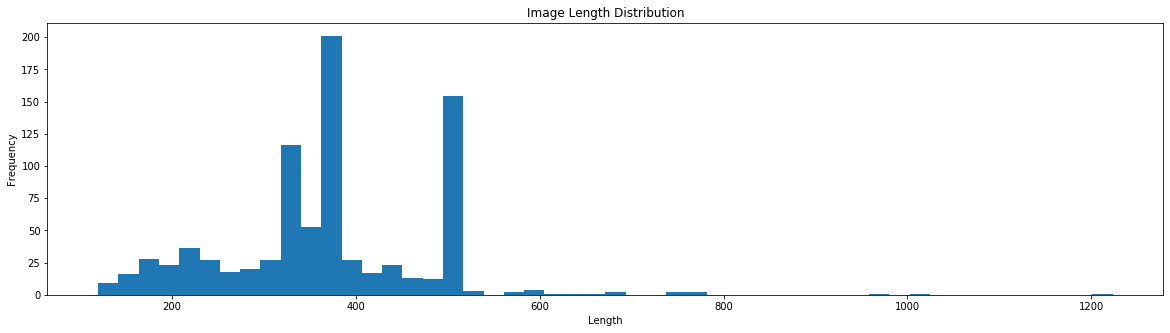

In [22]:
# Plot histograms
plt.figure(figsize=(20, 5))
plt.hist(lengths, bins=50)
plt.title("Image Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")

## Train-Test Split / DataLoader / Find mean and std

Since the data does not come split to train / test / eval, we need to create it ourselves.

In [23]:
# First create a dict of breeds and label
breed_dict = {bread:i for i, bread in enumerate(breed_list)}
breed_dict_invert = {val: key for key, val in breed_dict.items()}

In [24]:
all_filenames = []
for breed in tqdm(breed_dict):
    # Take care of each image (image+label)
    breed_path = BASE_PATH + "/Images/" + breed
    for img_file_name in os.listdir(breed_path):
        img_path = breed_path + "/" + img_file_name
        all_filenames.append(img_path)

/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [25]:
all_filenames[:5]

['/home/ishay/Documents/MDLI/dogs/data/Images/n02096437-Dandie_Dinmont/n02096437_3289.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02096437-Dandie_Dinmont/n02096437_2504.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02096437-Dandie_Dinmont/n02096437_1782.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02096437-Dandie_Dinmont/n02096437_2783.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02096437-Dandie_Dinmont/n02096437_48.jpg']

Now split the paths

In [26]:
train_eval_paths, test_paths = train_test_split(all_filenames, test_size=0.10, random_state=0)

In [27]:
train_paths, evel_paths = train_test_split(train_eval_paths, test_size=0.20, random_state=0)

In [28]:
print(len(train_paths), len(evel_paths), len(test_paths))

604 152 85


In [29]:
train_paths[:5]

['/home/ishay/Documents/MDLI/dogs/data/Images/n02106550-Rottweiler/n02106550_5710.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02091134-whippet/n02091134_10548.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02091134-whippet/n02091134_12029.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02088632-bluetick/n02088632_3737.jpg',
 '/home/ishay/Documents/MDLI/dogs/data/Images/n02091134-whippet/n02091134_16086.jpg']

## Create a Dataset Class

In [30]:
# The purpose of the Dataset class is to allow handling the iamges more easily.
class DogsDS(Dataset):
    def __init__(self, image_paths, annot_dir ,breed_dict, transform=None):
        
        self.paths = image_paths
        self.annot_dir = annot_dir
        self.breed_dict = breed_dict
        self.transform = transform
        # Here we store the data segments (image, class, box)
        self.images = []
        self.label_indices = []
        self.boxes = []
        
        # Iterate over all classes and images and collect to lists

        for path in tqdm(self.paths):
            #print(breed)
            # Split the path by "/"
            split_path = path.split("/")
            # We get something like: ['home',....,'Images','n02106550-Rottweiler','n02106550_5710.jpg']

            # Get the label index
            breed = split_path[-2]
            label_idx = self.breed_dict[breed]
            self.label_indices.append(label_idx)
            
            # img_image = io.imread(img_path)
            img_image = Image.open(path)
            self.images.append(img_image)

            # Now the box
            img_file_name = split_path[-1]
            annot_name = img_file_name.split(".")[0]
            annot_path = self.annot_dir + breed + "/" + annot_name
            # Extract the box attributes from the path
            tree = ET.parse(annot_path) # init parser for file given
            root = tree.getroot() # idk what's it but it's from documentation
            objects = root.findall('object') # finding all dogs. An array
            for o in objects:
                bndbox = o.find('bndbox') # reading border coordinates
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
            box = (xmin, ymin, xmax, ymax)
            self.boxes.append(box)
            
            
                    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return len(self.images)
    
    
    def __getitem__(self, index):
        """ 
        Get a sample from the dataset.
        input: index
        returns: a tuple of: image, label(index), box(tuple)
                 for example: (<image..>, 3, (114, 20, 298, 357))
        """
        # If dataset is preloaded
        image = self.images[index]
        label = self.label_indices[index]
        box = self.boxes[index]
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
            ###??? will probably have to do something with the box if we crop/flip
        # return image and label
        return image, label, box


In [31]:
annotations_paths = BASE_PATH + "/Annotation/"

In [32]:
# Must at least transform to tensor
transform = T.Compose([   
                T.Resize((500,375)),
                T.ToTensor(),
            ])

In [33]:
train_ds = DogsDS(train_paths, annotations_paths, breed_dict, transform)
evel_ds = DogsDS(evel_paths, annotations_paths, breed_dict, transform)
test_ds = DogsDS(test_paths, annotations_paths, breed_dict, transform)

/home/ishay/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


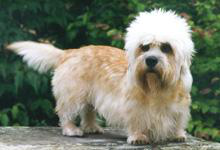

In [34]:
# Now examine one sample
# Examine image
sample_idx = 302
# Image
sample_image = train_ds.images[sample_idx]
sample_image

In [35]:
# Examine label
sample_label = train_ds.label_indices[sample_idx]
sample_label

0

In [36]:
breed_dict_invert[sample_label]

'n02096437-Dandie_Dinmont'

In [37]:
# Examine box
sample_box = train_ds.boxes[sample_idx]
sample_box

(5, 8, 200, 143)

In [38]:
xmin, ymin, xmax, ymax = sample_box[0], sample_box[1], sample_box[2], sample_box[3]

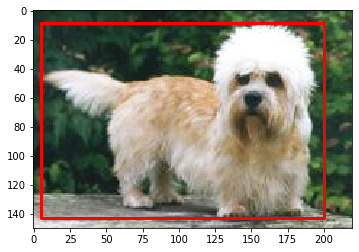

In [39]:
# Check that this is the right box:
plt.imshow(sample_image)
plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],  linewidth=3, c="r")

**COOL!**

**Although we transformed the image to tensor with the size of 500,375, the image remains the original** 

In [40]:
# Now use the get_item method
train_ds[100]

(tensor([[[0.3922, 0.3922, 0.3961,  ..., 0.2118, 0.2118, 0.2118],
          [0.4000, 0.4000, 0.4000,  ..., 0.2000, 0.2039, 0.2078],
          [0.4000, 0.4000, 0.4000,  ..., 0.1961, 0.1961, 0.2039],
          ...,
          [0.5059, 0.5059, 0.5098,  ..., 0.4588, 0.4588, 0.4510],
          [0.5098, 0.5137, 0.5137,  ..., 0.4549, 0.4549, 0.4510],
          [0.5137, 0.5176, 0.5216,  ..., 0.4549, 0.4588, 0.4549]],
 
         [[0.3843, 0.3843, 0.3882,  ..., 0.2118, 0.2118, 0.2118],
          [0.3922, 0.3922, 0.3922,  ..., 0.2000, 0.2039, 0.2078],
          [0.3922, 0.3922, 0.3922,  ..., 0.1961, 0.2000, 0.2039],
          ...,
          [0.5020, 0.5020, 0.5059,  ..., 0.4549, 0.4588, 0.4510],
          [0.5059, 0.5098, 0.5098,  ..., 0.4510, 0.4549, 0.4510],
          [0.5098, 0.5137, 0.5176,  ..., 0.4549, 0.4588, 0.4549]],
 
         [[0.3373, 0.3373, 0.3412,  ..., 0.2157, 0.2196, 0.2196],
          [0.3451, 0.3451, 0.3451,  ..., 0.2000, 0.2039, 0.2118],
          [0.3451, 0.3451, 0.3451,  ...,

In [41]:
train_ds[100][0]

tensor([[[0.3922, 0.3922, 0.3961,  ..., 0.2118, 0.2118, 0.2118],
         [0.4000, 0.4000, 0.4000,  ..., 0.2000, 0.2039, 0.2078],
         [0.4000, 0.4000, 0.4000,  ..., 0.1961, 0.1961, 0.2039],
         ...,
         [0.5059, 0.5059, 0.5098,  ..., 0.4588, 0.4588, 0.4510],
         [0.5098, 0.5137, 0.5137,  ..., 0.4549, 0.4549, 0.4510],
         [0.5137, 0.5176, 0.5216,  ..., 0.4549, 0.4588, 0.4549]],

        [[0.3843, 0.3843, 0.3882,  ..., 0.2118, 0.2118, 0.2118],
         [0.3922, 0.3922, 0.3922,  ..., 0.2000, 0.2039, 0.2078],
         [0.3922, 0.3922, 0.3922,  ..., 0.1961, 0.2000, 0.2039],
         ...,
         [0.5020, 0.5020, 0.5059,  ..., 0.4549, 0.4588, 0.4510],
         [0.5059, 0.5098, 0.5098,  ..., 0.4510, 0.4549, 0.4510],
         [0.5098, 0.5137, 0.5176,  ..., 0.4549, 0.4588, 0.4549]],

        [[0.3373, 0.3373, 0.3412,  ..., 0.2157, 0.2196, 0.2196],
         [0.3451, 0.3451, 0.3451,  ..., 0.2000, 0.2039, 0.2118],
         [0.3451, 0.3451, 0.3451,  ..., 0.1843, 0.1922, 0.

In [42]:
train_ds[100][1]

3

In [43]:
train_ds[100][2]

(107, 132, 271, 344)

## DataLoader

In [44]:
loader = DataLoader(
  train_ds,
  batch_size=10,
  num_workers=0,
  shuffle=False
)

In [45]:
len(train_ds)

604

In [46]:
for data in loader:
    print(data[0])

tensor([[[[0.9843, 0.4157, 0.1412,  ..., 0.4745, 0.6275, 0.9804],
          [0.9882, 0.4235, 0.1098,  ..., 0.4353, 0.6118, 0.9882],
          [0.9882, 0.4275, 0.1137,  ..., 0.4118, 0.5961, 0.9922],
          ...,
          [0.9961, 0.6392, 0.5490,  ..., 0.3216, 0.5725, 0.9804],
          [0.9882, 0.6235, 0.5569,  ..., 0.3294, 0.5804, 0.9804],
          [0.9843, 0.6196, 0.5608,  ..., 0.3412, 0.5882, 0.9843]],

         [[0.9922, 0.4196, 0.1373,  ..., 0.4471, 0.6235, 0.9922],
          [0.9961, 0.4235, 0.1059,  ..., 0.4000, 0.6000, 0.9961],
          [1.0000, 0.4314, 0.1098,  ..., 0.3725, 0.5843, 1.0000],
          ...,
          [0.9882, 0.6196, 0.5020,  ..., 0.3373, 0.5922, 0.9961],
          [0.9804, 0.6039, 0.5098,  ..., 0.3529, 0.6000, 0.9961],
          [0.9765, 0.6000, 0.5137,  ..., 0.3686, 0.6078, 1.0000]],

         [[1.0000, 0.4314, 0.1569,  ..., 0.4078, 0.5843, 0.9647],
          [1.0000, 0.4392, 0.1255,  ..., 0.3608, 0.5647, 0.9725],
          [1.0000, 0.4431, 0.1294,  ..., 0

tensor([[[[0.4196, 0.3804, 0.3294,  ..., 1.0000, 1.0000, 1.0000],
          [0.4196, 0.3804, 0.3294,  ..., 1.0000, 1.0000, 1.0000],
          [0.4275, 0.3882, 0.3333,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.3961, 0.3137, 0.2314,  ..., 0.6941, 0.6275, 0.5686],
          [0.4039, 0.2941, 0.1922,  ..., 0.7529, 0.6863, 0.6157],
          [0.4039, 0.2902, 0.1843,  ..., 0.7647, 0.6941, 0.6235]],

         [[0.5333, 0.4941, 0.4431,  ..., 1.0000, 1.0000, 1.0000],
          [0.5333, 0.4941, 0.4431,  ..., 1.0000, 1.0000, 1.0000],
          [0.5412, 0.5020, 0.4471,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.3255, 0.2431, 0.1647,  ..., 0.6784, 0.6157, 0.5608],
          [0.3333, 0.2235, 0.1216,  ..., 0.7373, 0.6706, 0.6000],
          [0.3333, 0.2196, 0.1137,  ..., 0.7490, 0.6784, 0.6078]],

         [[0.4157, 0.3765, 0.3255,  ..., 0.9804, 0.9804, 0.9804],
          [0.4157, 0.3765, 0.3255,  ..., 0.9804, 0.9804, 0.9804],
          [0.4235, 0.3843, 0.3294,  ..., 0

tensor([[[[0.3529, 0.3569, 0.4510,  ..., 0.3569, 0.3569, 0.3490],
          [0.3529, 0.3529, 0.3961,  ..., 0.3647, 0.3686, 0.3725],
          [0.3725, 0.3686, 0.3686,  ..., 0.3529, 0.3647, 0.3804],
          ...,
          [0.6275, 0.6392, 0.6353,  ..., 0.2078, 0.2431, 0.2000],
          [0.6510, 0.6392, 0.6392,  ..., 0.1804, 0.1922, 0.1255],
          [0.6784, 0.6471, 0.6431,  ..., 0.1686, 0.1647, 0.1020]],

         [[0.3529, 0.3569, 0.4431,  ..., 0.3412, 0.3412, 0.3333],
          [0.3490, 0.3490, 0.3922,  ..., 0.3490, 0.3529, 0.3569],
          [0.3686, 0.3686, 0.3686,  ..., 0.3373, 0.3490, 0.3647],
          ...,
          [0.6275, 0.6392, 0.6353,  ..., 0.1961, 0.2314, 0.1882],
          [0.6510, 0.6392, 0.6392,  ..., 0.1686, 0.1804, 0.1137],
          [0.6784, 0.6471, 0.6431,  ..., 0.1569, 0.1529, 0.0902]],

         [[0.2196, 0.2235, 0.3176,  ..., 0.2980, 0.2941, 0.2863],
          [0.2196, 0.2235, 0.2706,  ..., 0.3098, 0.3098, 0.3098],
          [0.2431, 0.2471, 0.2471,  ..., 0

tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0235],
          [0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0235],
          [0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.1804, 0.1922, 0.2039,  ..., 0.0157, 0.0157, 0.0157],
          [0.1765, 0.1804, 0.1882,  ..., 0.0157, 0.0157, 0.0157],
          [0.1725, 0.1765, 0.1804,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2627, 0.2745, 0.2824,  ..., 0.0157, 0.0157, 0.0157],
          [0.2588, 0.2627, 0.2667,  ..., 0.0157, 0.0157, 0.0157],
          [0.2549, 0.2549, 0.2549,  ..., 0.0157, 0.0157, 0.0157]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

tensor([[[[0.0980, 0.1020, 0.0863,  ..., 0.0039, 0.0000, 0.0353],
          [0.1098, 0.1059, 0.0863,  ..., 0.0000, 0.0000, 0.0392],
          [0.1255, 0.1294, 0.1098,  ..., 0.0000, 0.0000, 0.0431],
          ...,
          [0.2196, 0.3686, 0.2549,  ..., 0.1961, 0.2510, 0.2392],
          [0.2510, 0.3294, 0.2078,  ..., 0.1843, 0.2627, 0.2510],
          [0.2863, 0.2039, 0.2000,  ..., 0.1569, 0.2392, 0.2275]],

         [[0.1882, 0.2000, 0.1961,  ..., 0.3059, 0.2863, 0.2706],
          [0.2000, 0.2039, 0.1961,  ..., 0.2980, 0.2784, 0.2745],
          [0.2157, 0.2196, 0.2196,  ..., 0.3137, 0.2980, 0.2784],
          ...,
          [0.4000, 0.5490, 0.4353,  ..., 0.3137, 0.3608, 0.3490],
          [0.4314, 0.5098, 0.3882,  ..., 0.3020, 0.3725, 0.3608],
          [0.4667, 0.3843, 0.3804,  ..., 0.2745, 0.3490, 0.3373]],

         [[0.1176, 0.1176, 0.1098,  ..., 0.2314, 0.2353, 0.2392],
          [0.1294, 0.1216, 0.1098,  ..., 0.2235, 0.2275, 0.2431],
          [0.1373, 0.1412, 0.1333,  ..., 0

tensor([[[[0.6353, 0.5569, 0.6667,  ..., 0.5765, 0.6078, 0.6314],
          [0.6471, 0.6000, 0.6706,  ..., 0.6275, 0.6392, 0.6314],
          [0.6510, 0.6353, 0.6510,  ..., 0.6549, 0.6588, 0.6431],
          ...,
          [0.7804, 0.7961, 0.7961,  ..., 0.2039, 0.1569, 0.1412],
          [0.7529, 0.7882, 0.8235,  ..., 0.1922, 0.1608, 0.1373],
          [0.7373, 0.7882, 0.8471,  ..., 0.1882, 0.1647, 0.1333]],

         [[0.7098, 0.6039, 0.6863,  ..., 0.5098, 0.5412, 0.5647],
          [0.7216, 0.6471, 0.6941,  ..., 0.5608, 0.5725, 0.5647],
          [0.7255, 0.6863, 0.6745,  ..., 0.5882, 0.5922, 0.5765],
          ...,
          [0.7137, 0.7255, 0.7176,  ..., 0.1725, 0.1255, 0.1098],
          [0.6863, 0.7216, 0.7490,  ..., 0.1608, 0.1294, 0.1059],
          [0.6706, 0.7176, 0.7725,  ..., 0.1569, 0.1333, 0.1020]],

         [[0.3216, 0.2431, 0.3608,  ..., 0.3294, 0.3608, 0.3843],
          [0.3412, 0.2941, 0.3725,  ..., 0.3843, 0.3961, 0.3882],
          [0.3608, 0.3451, 0.3647,  ..., 0

tensor([[[[0.4941, 0.4196, 0.2863,  ..., 0.8314, 0.8000, 0.7922],
          [0.4863, 0.4039, 0.2784,  ..., 0.8353, 0.8196, 0.7882],
          [0.4745, 0.3882, 0.2667,  ..., 0.8353, 0.8431, 0.7843],
          ...,
          [0.9922, 0.9804, 0.9686,  ..., 0.6000, 0.5137, 0.5294],
          [0.9765, 0.9529, 0.9608,  ..., 0.6980, 0.6941, 0.6549],
          [0.9490, 0.9216, 0.9529,  ..., 0.6784, 0.7804, 0.7765]],

         [[0.4431, 0.3725, 0.2471,  ..., 0.7294, 0.7059, 0.6980],
          [0.4353, 0.3569, 0.2392,  ..., 0.7333, 0.7216, 0.6941],
          [0.4235, 0.3412, 0.2275,  ..., 0.7294, 0.7412, 0.6824],
          ...,
          [0.9804, 0.9686, 0.9529,  ..., 0.4980, 0.4118, 0.4275],
          [0.9725, 0.9412, 0.9451,  ..., 0.5922, 0.5882, 0.5490],
          [0.9490, 0.9176, 0.9412,  ..., 0.5686, 0.6706, 0.6667]],

         [[0.3686, 0.3020, 0.1804,  ..., 0.7098, 0.6902, 0.6824],
          [0.3608, 0.2863, 0.1725,  ..., 0.7059, 0.7059, 0.6745],
          [0.3490, 0.2667, 0.1608,  ..., 0

tensor([[[[0.4824, 0.4431, 0.4235,  ..., 0.5255, 0.5569, 0.5686],
          [0.4667, 0.4431, 0.4392,  ..., 0.5098, 0.5294, 0.5333],
          [0.4667, 0.4510, 0.4549,  ..., 0.5176, 0.5333, 0.5373],
          ...,
          [0.0078, 0.0196, 0.0275,  ..., 0.1020, 0.1216, 0.1176],
          [0.0118, 0.0118, 0.0118,  ..., 0.1020, 0.1216, 0.1176],
          [0.0157, 0.0039, 0.0000,  ..., 0.1020, 0.1216, 0.1176]],

         [[0.3216, 0.2824, 0.2627,  ..., 0.4588, 0.4902, 0.5020],
          [0.3059, 0.2824, 0.2784,  ..., 0.4431, 0.4627, 0.4667],
          [0.3059, 0.2902, 0.2941,  ..., 0.4510, 0.4667, 0.4706],
          ...,
          [0.0078, 0.0196, 0.0275,  ..., 0.0824, 0.1020, 0.0980],
          [0.0118, 0.0118, 0.0118,  ..., 0.0824, 0.1020, 0.0980],
          [0.0157, 0.0039, 0.0000,  ..., 0.0824, 0.1020, 0.0980]],

         [[0.3373, 0.2980, 0.2784,  ..., 0.3961, 0.4275, 0.4392],
          [0.3216, 0.2980, 0.2941,  ..., 0.3804, 0.4000, 0.4039],
          [0.3216, 0.3059, 0.3098,  ..., 0

tensor([[[[0.9765, 0.9529, 0.9686,  ..., 0.8980, 0.8980, 0.8980],
          [0.9725, 0.9490, 0.9608,  ..., 0.8941, 0.8941, 0.8941],
          [0.9647, 0.9451, 0.9529,  ..., 0.8902, 0.8902, 0.8902],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.9765, 0.9529, 0.9686,  ..., 0.8667, 0.8667, 0.8667],
          [0.9725, 0.9490, 0.9608,  ..., 0.8627, 0.8627, 0.8627],
          [0.9647, 0.9451, 0.9529,  ..., 0.8588, 0.8588, 0.8588],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.9765, 0.9529, 0.9686,  ..., 0.8549, 0.8549, 0.8549],
          [0.9725, 0.9490, 0.9608,  ..., 0.8510, 0.8510, 0.8510],
          [0.9647, 0.9451, 0.9529,  ..., 0

tensor([[[[0.9961, 0.9961, 1.0000,  ..., 0.9647, 0.9725, 0.9765],
          [0.9961, 0.9961, 1.0000,  ..., 0.9647, 0.9725, 0.9765],
          [0.9922, 0.9922, 0.9961,  ..., 0.9686, 0.9725, 0.9765],
          ...,
          [0.7451, 0.7451, 0.7373,  ..., 0.6431, 0.6275, 0.6196],
          [0.7529, 0.7529, 0.7451,  ..., 0.6706, 0.6510, 0.6431],
          [0.7529, 0.7529, 0.7451,  ..., 0.6706, 0.6510, 0.6431]],

         [[0.9922, 0.9922, 0.9961,  ..., 0.9882, 0.9961, 1.0000],
          [0.9922, 0.9922, 0.9961,  ..., 0.9882, 0.9961, 1.0000],
          [0.9882, 0.9882, 0.9922,  ..., 0.9922, 0.9961, 1.0000],
          ...,
          [0.7961, 0.7961, 0.7882,  ..., 0.6078, 0.5922, 0.5843],
          [0.8039, 0.8039, 0.7961,  ..., 0.6392, 0.6196, 0.6118],
          [0.8039, 0.8039, 0.7961,  ..., 0.6392, 0.6196, 0.6118]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9882, 0.9961, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0

tensor([[[[0.2824, 0.2824, 0.2745,  ..., 0.2510, 0.2510, 0.2549],
          [0.2824, 0.2824, 0.2745,  ..., 0.2588, 0.2588, 0.2627],
          [0.2824, 0.2824, 0.2745,  ..., 0.2667, 0.2706, 0.2706],
          ...,
          [0.4314, 0.3882, 0.4000,  ..., 0.6078, 0.6588, 0.6784],
          [0.4667, 0.4275, 0.4196,  ..., 0.5647, 0.6235, 0.6471],
          [0.5451, 0.5059, 0.4275,  ..., 0.5882, 0.6275, 0.6627]],

         [[0.2667, 0.2667, 0.2588,  ..., 0.2549, 0.2549, 0.2588],
          [0.2667, 0.2667, 0.2588,  ..., 0.2627, 0.2627, 0.2667],
          [0.2667, 0.2667, 0.2588,  ..., 0.2706, 0.2745, 0.2745],
          ...,
          [0.3882, 0.3412, 0.3373,  ..., 0.5098, 0.5608, 0.5804],
          [0.4157, 0.3725, 0.3529,  ..., 0.4667, 0.5255, 0.5490],
          [0.4784, 0.4392, 0.3608,  ..., 0.4706, 0.5098, 0.5451]],

         [[0.2235, 0.2235, 0.2157,  ..., 0.2314, 0.2314, 0.2353],
          [0.2235, 0.2235, 0.2157,  ..., 0.2392, 0.2392, 0.2431],
          [0.2235, 0.2235, 0.2157,  ..., 0

tensor([[[[0.3922, 0.3176, 0.2549,  ..., 0.2902, 0.2941, 0.2980],
          [0.3882, 0.3137, 0.2510,  ..., 0.2863, 0.2902, 0.2941],
          [0.3804, 0.3059, 0.2431,  ..., 0.2745, 0.2784, 0.2824],
          ...,
          [0.4784, 0.4275, 0.3804,  ..., 0.4275, 0.4392, 0.4510],
          [0.4706, 0.4314, 0.3843,  ..., 0.4314, 0.4431, 0.4549],
          [0.4667, 0.4314, 0.3843,  ..., 0.4353, 0.4471, 0.4549]],

         [[0.4471, 0.3725, 0.3098,  ..., 0.3490, 0.3569, 0.3608],
          [0.4431, 0.3686, 0.3059,  ..., 0.3451, 0.3529, 0.3569],
          [0.4353, 0.3608, 0.2980,  ..., 0.3333, 0.3412, 0.3451],
          ...,
          [0.5373, 0.4863, 0.4353,  ..., 0.5098, 0.5216, 0.5333],
          [0.5294, 0.4902, 0.4392,  ..., 0.5137, 0.5255, 0.5373],
          [0.5255, 0.4902, 0.4431,  ..., 0.5176, 0.5294, 0.5373]],

         [[0.3490, 0.2745, 0.2118,  ..., 0.2235, 0.2235, 0.2196],
          [0.3451, 0.2706, 0.2078,  ..., 0.2196, 0.2196, 0.2157],
          [0.3373, 0.2627, 0.2000,  ..., 0

tensor([[[[0.4745, 0.4667, 0.4471,  ..., 0.4314, 0.4510, 0.4706],
          [0.4863, 0.4784, 0.4588,  ..., 0.4431, 0.4588, 0.4745],
          [0.4902, 0.4863, 0.4745,  ..., 0.4549, 0.4627, 0.4706],
          ...,
          [0.5373, 0.4902, 0.4275,  ..., 0.4863, 0.4902, 0.4549],
          [0.5333, 0.4902, 0.4235,  ..., 0.5059, 0.5529, 0.5333],
          [0.5137, 0.4863, 0.4235,  ..., 0.4980, 0.6039, 0.5843]],

         [[0.5490, 0.5373, 0.5176,  ..., 0.4863, 0.5059, 0.5255],
          [0.5569, 0.5490, 0.5294,  ..., 0.4980, 0.5137, 0.5294],
          [0.5569, 0.5529, 0.5412,  ..., 0.5098, 0.5176, 0.5255],
          ...,
          [0.6157, 0.5686, 0.5020,  ..., 0.4118, 0.4431, 0.4471],
          [0.6118, 0.5686, 0.4980,  ..., 0.4314, 0.5020, 0.5294],
          [0.5922, 0.5647, 0.4980,  ..., 0.4196, 0.5529, 0.5804]],

         [[0.1373, 0.1255, 0.0941,  ..., 0.0471, 0.0627, 0.0863],
          [0.1490, 0.1373, 0.1059,  ..., 0.0549, 0.0706, 0.0902],
          [0.1490, 0.1412, 0.1176,  ..., 0

tensor([[[[0.5373, 0.5255, 0.4667,  ..., 0.0588, 0.0706, 0.0667],
          [0.5098, 0.5294, 0.5098,  ..., 0.0510, 0.0627, 0.0588],
          [0.4745, 0.5176, 0.5490,  ..., 0.0549, 0.0667, 0.0588],
          ...,
          [0.2235, 0.3216, 0.2392,  ..., 0.3373, 0.3373, 0.3294],
          [0.1569, 0.2745, 0.3020,  ..., 0.3373, 0.3373, 0.3294],
          [0.0863, 0.1725, 0.3294,  ..., 0.3412, 0.3373, 0.3294]],

         [[0.4039, 0.3961, 0.3451,  ..., 0.0980, 0.1176, 0.1137],
          [0.3804, 0.4000, 0.3922,  ..., 0.0941, 0.1098, 0.1020],
          [0.3490, 0.3961, 0.4314,  ..., 0.0980, 0.1137, 0.1020],
          ...,
          [0.2980, 0.3882, 0.2863,  ..., 0.2353, 0.2353, 0.2275],
          [0.2353, 0.3451, 0.3529,  ..., 0.2353, 0.2353, 0.2275],
          [0.1686, 0.2471, 0.3882,  ..., 0.2353, 0.2353, 0.2275]],

         [[0.2275, 0.2196, 0.1647,  ..., 0.0471, 0.0627, 0.0588],
          [0.2039, 0.2235, 0.2118,  ..., 0.0392, 0.0471, 0.0431],
          [0.1725, 0.2196, 0.2549,  ..., 0

tensor([[[[0.2941, 0.3098, 0.3333,  ..., 0.5373, 0.5569, 0.5765],
          [0.3020, 0.3176, 0.3373,  ..., 0.5294, 0.5490, 0.5647],
          [0.3098, 0.3216, 0.3373,  ..., 0.5216, 0.5412, 0.5490],
          ...,
          [0.5490, 0.6431, 0.6902,  ..., 0.5216, 0.5451, 0.5098],
          [0.5451, 0.6000, 0.6118,  ..., 0.5294, 0.5373, 0.5216],
          [0.5490, 0.5569, 0.5255,  ..., 0.5333, 0.5294, 0.5255]],

         [[0.5451, 0.5608, 0.5843,  ..., 0.4980, 0.5137, 0.5373],
          [0.5569, 0.5686, 0.5882,  ..., 0.5020, 0.5176, 0.5333],
          [0.5686, 0.5725, 0.5922,  ..., 0.5059, 0.5216, 0.5333],
          ...,
          [0.4902, 0.5804, 0.6157,  ..., 0.5725, 0.5922, 0.5490],
          [0.4824, 0.5294, 0.5294,  ..., 0.5922, 0.6000, 0.5765],
          [0.4784, 0.4824, 0.4392,  ..., 0.6039, 0.5961, 0.5882]],

         [[0.2039, 0.2196, 0.2471,  ..., 0.2784, 0.2941, 0.3059],
          [0.2078, 0.2235, 0.2510,  ..., 0.2745, 0.2902, 0.3020],
          [0.2118, 0.2275, 0.2510,  ..., 0

tensor([[[[0.3176, 0.4000, 0.4235,  ..., 0.2157, 0.2863, 0.3059],
          [0.2902, 0.3529, 0.3647,  ..., 0.2392, 0.2980, 0.2863],
          [0.2627, 0.3098, 0.3176,  ..., 0.2706, 0.3098, 0.2980],
          ...,
          [0.2314, 0.3529, 0.2235,  ..., 0.3373, 0.3216, 0.4078],
          [0.4549, 0.4863, 0.1765,  ..., 0.5608, 0.4000, 0.5373],
          [0.7098, 0.5529, 0.1725,  ..., 0.7020, 0.4118, 0.5569]],

         [[0.3059, 0.3843, 0.3922,  ..., 0.4000, 0.4784, 0.4980],
          [0.2745, 0.3333, 0.3294,  ..., 0.4235, 0.4902, 0.4784],
          [0.2431, 0.2863, 0.2784,  ..., 0.4549, 0.5020, 0.4902],
          ...,
          [0.2980, 0.3843, 0.2078,  ..., 0.3412, 0.3294, 0.4157],
          [0.5098, 0.5059, 0.1529,  ..., 0.5608, 0.3922, 0.5373],
          [0.7608, 0.5647, 0.1451,  ..., 0.6941, 0.3961, 0.5490]],

         [[0.0431, 0.1255, 0.1490,  ..., 0.1529, 0.2235, 0.2431],
          [0.0275, 0.0784, 0.0863,  ..., 0.1725, 0.2353, 0.2235],
          [0.0118, 0.0353, 0.0392,  ..., 0

For each instance of DataLoader, the first([0]) is a tensor, the second is an integer of the label, and the third is the tuple with the box attributes.

In [47]:
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for data in loader:
        b, c, h, w = data[0].size()
        nb_pixels = b * h * w
        sum_ = torch.sum(data[0], dim=[0, 2, 3])
        sum_of_square = torch.sum(data[0] ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [48]:

mean, std = online_mean_and_sd(loader)

In [49]:
mean

tensor([0.4815, 0.4620, 0.3950])

In [50]:
std

tensor([0.2606, 0.2511, 0.2552])

In [51]:
mean = 0.
meansq = 0.
# First extract all tensors
tensors = [data[0] for data in loader]

# Then calculate the mean per RGB channel

mean_R = torch.mean(torch.tensor([torch.mean(tens[0]) for tens in tensors]))
mean_G = torch.mean(torch.tensor([torch.mean(tens[1]) for tens in tensors]))
mean_B = torch.mean(torch.tensor([torch.mean(tens[2]) for tens in tensors]))

# Calculate the std
# Var first
var_R = torch.mean(torch.tensor([(torch.mean(tens[0])-mean_R)**2 for tens in tensors]))
var_G = torch.mean(torch.tensor([(torch.mean(tens[1])-mean_G)**2 for tens in tensors]))
var_B = torch.mean(torch.tensor([(torch.mean(tens[2])-mean_B)**2 for tens in tensors]))

# std
std_R = torch.sqrt(var_R)
std_G = torch.sqrt(var_G)
std_B = torch.sqrt(var_B)

print("mean: ", (mean_R, mean_G, mean_B))
print("std: ", (std_R, std_G, std_B))
print()

mean:  (tensor(0.4128), tensor(0.4419), tensor(0.4520))
std:  (tensor(0.0863), tensor(0.1087), tensor(0.1026))



In [52]:
#MM - changed loader.batch_size to len(train_ds)
mean_R = mean_G = mean_B = 0.0
var_R = var_G = var_B = 0.0

for images in loader:
    mean_R += torch.mean(images[0][0])
    mean_G += torch.mean(images[0][1])
    mean_B += torch.mean(images[0][2])

mean_R /= len(train_ds)
mean_G /= len(train_ds)
mean_B /= len(train_ds)
    
for images in loader:
    var_R += (torch.mean(images[0][0]) - mean_R)**2
    var_G += (torch.mean(images[0][1]) - mean_G)**2
    var_B += (torch.mean(images[0][2]) - mean_B)**2

var_R /= len(train_ds)
var_G /= len(train_ds)
var_B /= len(train_ds)

print("mean: ", (mean_R, mean_G, mean_B)) 
print("std: ", (std_R, std_G, std_B))

mean:  (tensor(0.0417), tensor(0.0446), tensor(0.0456))
std:  (tensor(0.0863), tensor(0.1087), tensor(0.1026))


In [ ]:
# # OLD DogsDS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# # The purpose of the Dataset class is to allow handling the iamges more easily.
# class DogsDS(Dataset):
#     def __init__(self, img_dir, annot_dir, breed_dict, transform=None):
        
#         self.img_dir = img_dir
#         self.annot_dir = annot_dir
#         self.breed_dict = breed_dict
#         self.transform = transform
#         # Here we store the data segments (image, class, box)
#         self.images = []
#         self.label_indices = []
#         self.boxes = []
        
#         # Iterate over all classes and images and collect to lists

#         for breed in tqdm(self.breed_dict):
#             #print(breed)
#             # Take care of the label index
#             label_idx = self.breed_dict[breed]
            
#             # Take care of each image (image+label)
#             breed_path = self.img_dir + breed
#             for img_file_name in os.listdir(breed_path):
#                 img_path = breed_path + "/" + img_file_name
        
#                 # img_image = io.imread(img_path)
#                 img_image = Image.open(img_path)
#                 self.images.append(img_image)
#                 self.label_indices.append(label_idx)
                
#                 # Now the box
#                 annot_name = img_file_name.split(".")[0]
#                 annot_path = self.annot_dir + breed + "/" + annot_name
#                 # Extract the box attributes from the path
#                 tree = ET.parse(annot_path) # init parser for file given
#                 root = tree.getroot() # idk what's it but it's from documentation
#                 objects = root.findall('object') # finding all dogs. An array
#                 for o in objects:
#                     bndbox = o.find('bndbox') # reading border coordinates
#                     xmin = int(bndbox.find('xmin').text)
#                     ymin = int(bndbox.find('ymin').text)
#                     xmax = int(bndbox.find('xmax').text)
#                     ymax = int(bndbox.find('ymax').text)
#                 box = (xmin, ymin, xmax, ymax)
#                 self.boxes.append(box)
                
                
#     def __len__(self):
#         """
#         Total number of samples in the dataset
#         """
#         return len(self.images)
    
    
#     def __getitem__(self, index):
#         """ 
#         Get a sample from the dataset.
#         input: index
#         returns: a tuple of: image, label(index), box(tuple)
#                  for example: (<image..>, 3, (114, 20, 298, 357))
#         """
#         # If dataset is preloaded
#         image = self.images[index]
#         label = self.label_indices[index]
#         box = self.boxes[index]
            
#         # May use transform function to transform samples
#         # e.g., random crop, whitening
#         if self.transform is not None:
#             image = self.transform(image)
#             ###??? will probably have to do something with the box if we crop/flip
#         # return image and label
#         return image, label, box

                